In [52]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.optimize as opt
from IPython.display import display
from ipywidgets import IntProgress

## Analysis of the noise in the image
We start by looking at the difference of the original image and the image with noise. If the difference between the original image and the image with noise is the gaussian noise, we should expect the difference to be a gaussian noise.

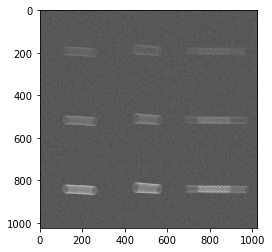

In [3]:
# reading in the images
im = Image.open("./data/tif/CDStent.tif")
im_noised = Image.open("./data/tif/CDStent_noise4.tif")

# conversion to numpy array
im_arr = np.array(im, dtype=float)
im_arr_noised = np.array(im_noised, dtype=float)

# extraction of the difference
diff = im_arr_noised - im_arr

# visualization of the difference
plt.imshow(diff, cmap="gray")

As we can see, the difference between the two images isn't a homogenous noise. The zones where the stent is present have a different shade than the zone where the stent is not present.

This problem is due to the fact that the tif files of both the original image and the noised image have been normalized using their minimum values and maximum values in the raw data. Using the following formulae:

    $$image_{normalized} = \frac{image-min(image)}{max(image)-min(image)}$$

And adding noise to the original image changes the values of min(x) and max(x).

Empirically, we find that when $\alpha = 0.67%$, the standard deviation of the $image - image_{noise}$ is minimal. Let's try to recreate the same conditions to obtain similar noised images.

3.6557805908106054

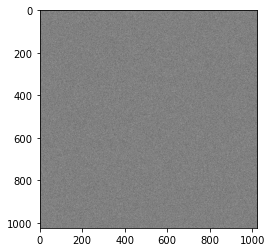

In [24]:
# difference between the noised image and 1/3 of the original image
noise = im_arr_noised - im_arr / 3

scipy.optimize.minimize(lambda alpha: np.mean(im_arr_noised - alpha * im_arr), 0.577)

# visualization of the noise
plt.imshow(noise, cmap="gray")

np.mean(noise) / np.std(im_arr)

As we can see from the visualization, subtracting the noised image by 1/3 of the original image gives us a homogenous noise. By denoting $G_{\mu, \sigma}(x, y)$ the noise (a random variable) at pixel x,y with a gaussian distribution of the noise of mean $\mu$ and standard deviation $\sigma$ , $O(x, y)$ as the original image and $N(x, y)$ as the noised image, we have the following:

$$ N(x, y) = \frac{1}{3} \cdot O(x, y) + G_{\mu, \sigma}(x, y) $$

where $G(x, y, \mu,\sigma)$ is the gaussian noise.

In the following Section, we're going to analyse the mean and the standard deviation of the above noise. Note that when the noise was created in the raw format, the mean and standard deviation of the noise before the normalization are different. We're simply applying a trick to obtain values that allow us to create similar noised images, so that we can train our model on a dataset with fixed std and mean values, before going onto creating noise with random standard deviations.

## Noise analysis
We start by looking at the mean and the standard deviation of the noise.
Note that the image that we're reading is coded in 16-bit signed integer, therefore the mean and average may vary depending on

In [26]:
# mean and standard deviation of the noise
mu = np.mean(noise)
sigma = np.std(noise)
print(f"The mean of the noise is               {mu}")
print(f"The standard deviation of the noise is {sigma}")

The mean of the noise is               15802.056997617085
The standard deviation of the noise is 5595.862325808515


Let's try to recreate the noised image by adding the noise to the original image and compare it to the noised image that we have to verify our assumptions visually.

Recreated noised image :


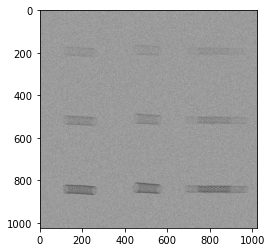

In [33]:
# recreation of the noised image with our parameters
im_arr_noised_recreated = im_arr / 3 + np.random.normal(loc=mu, scale=sigma, size=im_arr.shape)
print("Recreated noised image :")
plt.imshow(im_arr_noised_recreated, cmap="gray")

Noised image :


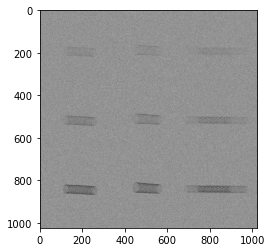

In [34]:
# comparison with the noised image that we're given
print("Noised image :")
plt.imshow(im_arr_noised, cmap="gray")

We can see that the two images are visually similar. Let's further verify our assumptions by plotting the difference of the two images and verify that its mean of the difference is close to 0:

In [35]:
# difference between the noised image and the recreated noised image
diff = im_arr_noised_recreated - im_arr_noised
# mean of the difference
print(f"The mean of the difference is {np.mean(diff)}")

The mean of the difference is -5.861370427116034


Given that our images are coded in 16 bits (with a maximum value of 2 * 16 - 1), the above mean of the difference between the two noises can be considered to be close to zero. (We would like to re-emphasize the fact that this step is just an empirical trick to obtain similarly noised images, and noise with different standard-deviations will be applied later in the project.)

## Generating noised images

In [36]:
def generate_noised_image_arr(im_arr, mean: float =mu, std: float =sigma):
    """
    Generate a noised pixel array from an original image array.
    """
    return im_arr / 3 + np.random.normal(loc=mean, scale=std, size=im_arr.shape)

def generate_noised_image(im: Image.Image, mean=mu, std=sigma):
    """
    Generate a noised PIL image from an original image.
    """
    im_arr = np.array(im, dtype=float)
    im_arr_noised = generate_noised_image_arr(im_arr, mean, std)
    return Image.fromarray(im_arr_noised.astype(np.uint16))

Let's test our functions.

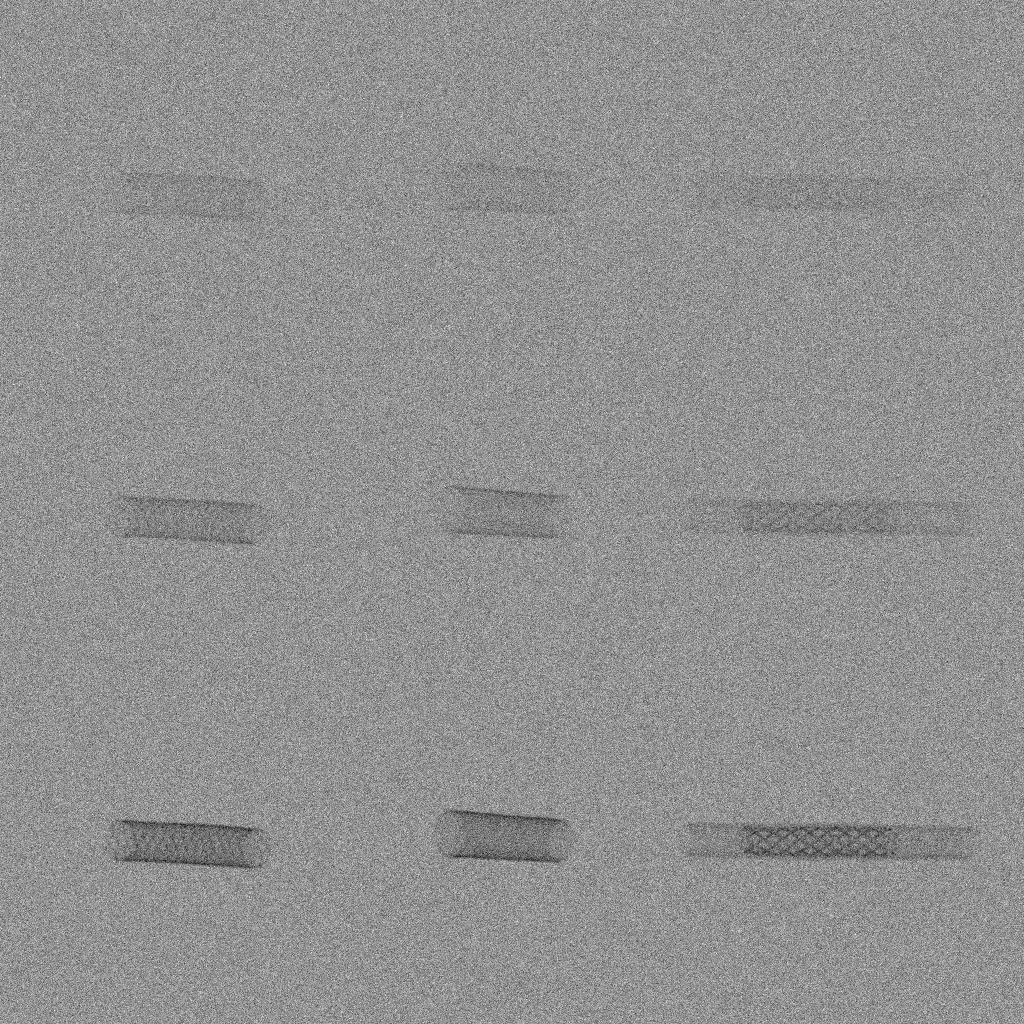

In [37]:
# reading in the images
im = Image.open("./data/png/CDStent.png")
im_noised = generate_noised_image(im)
im_noised

## Application of our functions to the whole dataset

In [38]:
# path to the ground truth / original images of the dataset
path_to_train_y = "./data/dataset/train/y"
path_to_test_y = "./data/dataset/test/y"

# list of the images in the dataset
list_of_images_train = os.listdir(path_to_train_y)
list_of_images_test = os.listdir(path_to_test_y)

# directory where we want to store the noised images
path_to_train_x = "./data/dataset/train/x"
path_to_test_x = "./data/dataset/test/x"

In [47]:
# creation of the directories
if not os.path.exists(path_to_train_x):
    os.makedirs(path_to_train_x)
if not os.path.exists(path_to_test_x):
    os.makedirs(path_to_test_x)

In [66]:
# display the progress bar
progress_bar = IntProgress(min=0, max=len(list_of_images_train))
display(progress_bar)
# loop over the images in the training set
for image_name in list_of_images_train:
    # reading in the image
    im = Image.open(os.path.join(path_to_train_y, image_name))
    # noised image
    im_noised = generate_noised_image(im)
    # saving the noised image
    im_noised.save(os.path.join(path_to_train_x, image_name))
    # updating the progress
    progress_bar.value += 1

IntProgress(value=0, max=1600)

KeyboardInterrupt: 

In [ ]:
# display the progress bar
progress_bar = IntProgress(min=0, max=len(list_of_images_test))
print("Progress: ", end="")
display(progress_bar)
# loop over the images in the test set
for image_name in list_of_images_test:
    # reading in the image
    im = Image.open(os.path.join(path_to_test_y, image_name))
    # noised image
    im_noised = generate_noised_image(im)
    # saving the noised image
    im_noised.save(os.path.join(path_to_test_x, image_name))
    # updating the progress
    progress_bar.value += 1

Progress: 

IntProgress(value=0, max=400)